# ism Import and Plotting

This notebook gives an example of the use case of measuring an impedance spectrum with Python via Thales Remote2.
This impedance spectrum is then imported into Python and plotted with matplotlib.

## 1. Connect Python to the already launched Thales-Software

In [2]:
import sys
from thales_remote.connection import ThalesRemoteConnection
from thales_remote.script_wrapper import PotentiostatMode,ThalesRemoteScriptWrapper

'''
Import the ISM import package and the matplotlib plotting library.
'''
from thales_file_import.ism_import import IsmImport
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter

TARGET_HOST = "localhost"

if __name__ == "__main__":
    '''
    The Thales software must first be started so that it can be connected.
    '''
    ZenniumConnection = ThalesRemoteConnection()
    connectionSuccessful = ZenniumConnection.connectToTerm(TARGET_HOST, "ScriptRemote")
    if connectionSuccessful:
        print("connection successfull")
    else:
        print("connection not possible")
        sys.exit()
          
    ZahnerZennium = ThalesRemoteScriptWrapper(ZenniumConnection)
  
    ZahnerZennium.forceThalesIntoRemoteScript()

connection successfull


## 2. Setting the parameters for the measurement

After the connection with Thales, the naming of the files of the measurement results is set.

Measure EIS spectra with a sequential number in the file name that has been specified.
Starting with number 1.

In [ ]:
    ZahnerZennium.setEISNaming("counter")
    ZahnerZennium.setEISCounter(1)
    ZahnerZennium.setEISOutputPath(r"C:\THALES\temp\test1")
    ZahnerZennium.setEISOutputFileName("spectra")

Setting the parameters for the spectra.
Alternatively a rule file can be used as a template.

In [ ]:
    ZahnerZennium.setPotentiostatMode(PotentiostatMode.POTMODE_POTENTIOSTATIC)
    ZahnerZennium.setAmplitude(10e-3)
    ZahnerZennium.setPotential(0)
    ZahnerZennium.setLowerFrequencyLimit(0.05)
    ZahnerZennium.setStartFrequency(1000)
    ZahnerZennium.setUpperFrequencyLimit(200000)
    ZahnerZennium.setLowerNumberOfPeriods(3)
    ZahnerZennium.setLowerStepsPerDecade(5)
    ZahnerZennium.setUpperNumberOfPeriods(20)
    ZahnerZennium.setUpperStepsPerDecade(10)
    ZahnerZennium.setScanDirection("startToMax")
    ZahnerZennium.setScanStrategy("single")

After setting the parameters, the measurement is started.  
Switching on the potentiostat before the measurement, so that EIS is measured at the set DC potential.  
If the potentiostat is off before the measurement, the measurement is performed at the OCP.  
After the measurement the potentiostat is switched off.

In [ ]:
    ZahnerZennium.enablePotentiostat()
    ZahnerZennium.measureEIS()
    ZahnerZennium.disablePotentiostat()
    ZenniumConnection.disconnectFromTerm()

## 3. Importing the ism file

Import the spectrum from the previous measurement. This was saved under the set path and name with the number expanded.  
The measurement starts at 1 therefore the following path results: "C:\THALES\temp\test1\spectra_0001.ism".

In [3]:
    ismFile = IsmImport(r"C:\THALES\temp\test1\spectra_0001.ism")
    
    impedanceFrequencies = ismFile.getFrequencyArray()
    
    impedanceAbsolute = ismFile.getImpedanceArray()
    impedancePhase = ismFile.getPhaseArray()
    
    impedanceComplex = ismFile.getComplexImpedanceArray()

The Python datetime object of the measurement date is output to the console next.

In [4]:
    print("Measurement end time: " + str(ismFile.getMeasurementEndDateTime()))

Measurement end time: 2021-02-23 15:37:13.698000


## 4. Displaying the measurement results

The spectra are presented in the Bode and Nyquist representation.  
For this test, the Zahner test box was measured in the lin position.

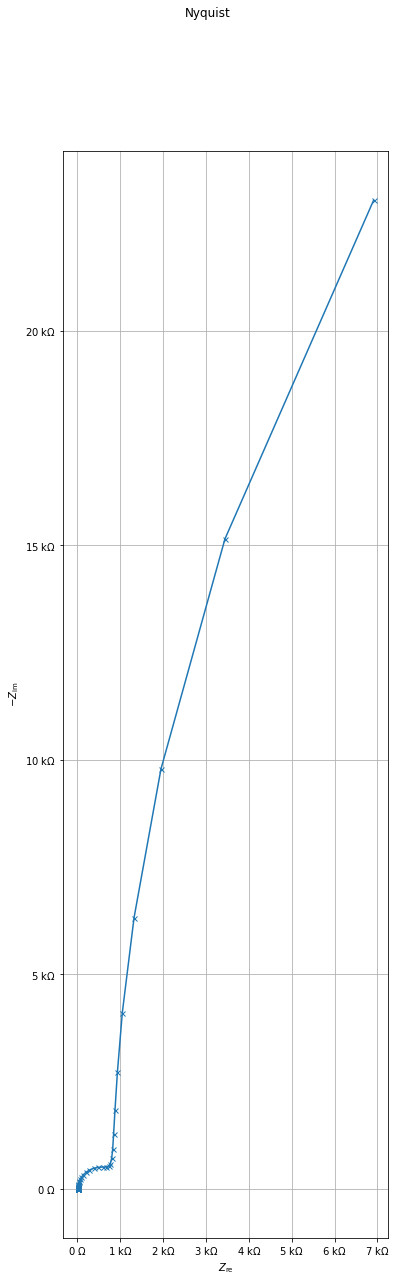

In [10]:
    plt.ion()
    figNyquist, (nyquistAxis) = plt.subplots(1, 1)
    figNyquist.suptitle("Nyquist")
    
    nyquistAxis.plot(np.real(impedanceComplex), -np.imag(impedanceComplex), marker="x", markersize=5)
    nyquistAxis.grid(which="both")
    nyquistAxis.set_aspect("equal)
    nyquistAxis.xaxis.set_major_formatter(EngFormatter(unit="$\Omega$"))
    nyquistAxis.yaxis.set_major_formatter(EngFormatter(unit="$\Omega$"))
    nyquistAxis.set_xlabel(r"$Z_{\rm re}$")
    nyquistAxis.set_ylabel(r"$-Z_{\rm im}$")
    figNyquist.set_size_inches(20, 20)
    plt.show()

Bode representation.
Display the data in the chart and then format the axes.

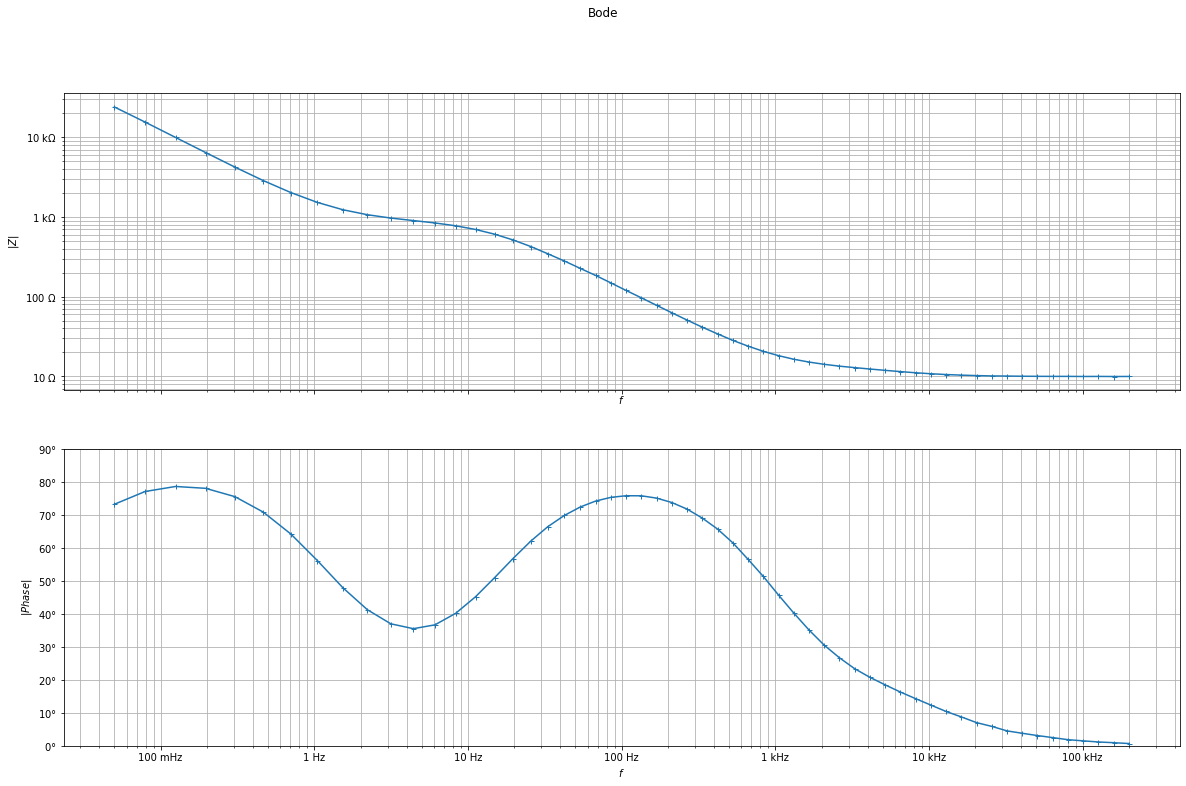

In [12]:
    figBode, (impedanceAxis, phaseAxis) = plt.subplots(2, 1, sharex=True)
    figBode.suptitle("Bode")
    
    impedanceAxis.loglog(impedanceFrequencies, impedanceAbsolute, marker="+", markersize=5)
    impedanceAxis.xaxis.set_major_formatter(EngFormatter(unit="Hz"))
    impedanceAxis.yaxis.set_major_formatter(EngFormatter(unit="$\Omega$"))
    impedanceAxis.set_xlabel(r"$f$")
    impedanceAxis.set_ylabel(r"$|Z|$")
    impedanceAxis.grid(which="both")
    
    phaseAxis.semilogx(impedanceFrequencies, np.abs(impedancePhase * (360 / (2 * np.pi))), marker="+", markersize=5)
    phaseAxis.xaxis.set_major_formatter(EngFormatter(unit="Hz"))
    phaseAxis.yaxis.set_major_formatter(EngFormatter(unit="$°$", sep=""))
    phaseAxis.set_xlabel(r"$f$")
    phaseAxis.set_ylabel(r"$|Phase|$")
    phaseAxis.grid(which="both")
    phaseAxis.set_ylim([0, 90])
    figBode.set_size_inches(20, 12)
    plt.show()